<h1>Gradients and activations functions</h1>

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PilotLeoYan/inside-deep-learning/blob/main/3-multilayer-perceptron/gradients-and-activation-functions.ipynb">
    <img src="../images/colab_logo.png" width="32">Open in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://nbviewer.org/github/PilotLeoYan/inside-deep-learning/blob/main/3-multilayer-perceptron/gradients-and-activation-functions.ipynb">
    <img src="../images/jupyter_logo.png" width="32">Open in Google Colab</a>
  </td>
</table>

In this notebook we will explore the derivatives of 
different activation functions such as ReLU, Sigmoid and Tanh. 
In addition, we will explore the derivatives of the dense layer, 
some of which are already known, but there is a new derivative that needs to be explored.

In [1]:
from autograd import jacobian, numpy as np

from platform import python_version
python_version()

'3.13.2'

In [2]:
import os
import sys

# Add the module path if running locally
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

try:
    # Try importing the module normally (for local execution)
    from tools.numpy_metrics import np_mape as mape
except ModuleNotFoundError:
    # If the module is not found, assume the code is running in Google Colab
    import subprocess

    repo_url = "https://raw.githubusercontent.com/PilotLeoYan/inside-deep-learning/main/tools/numpy_metrics.py"
    local_file = "numpy_metrics.py"

    # Download the missing file from GitHub
    subprocess.run(["wget", repo_url, "-O", local_file], check=True)

    # Import the module after downloading it
    import tools
    from numpy_metrics import np_mape as mape

# forward propagation

In [3]:
M: int = 100 # number of samples
N: int = 8 # number of input features
NO: int = 4 # number of output features

In [4]:
X = np.random.randn(M, N)
X.shape

(100, 8)

## dense

### parameters

$$
\begin{align*}
\mathbf{W}^{(k)} &\in \mathbb{R}^{n_{k-1} \times n_{k}} \\
\mathbf{b}^{(k)} &\in \mathbb{R}^{n_{k}}
\end{align*}
$$

In [5]:
bias: np.ndarray = np.random.randn(NO)
bias.shape

(4,)

In [6]:
weight: np.ndarray = np.random.randn(N, NO)
weight.shape

(8, 4)

### weighted sum

$$
\mathbf{Z}^{(k)} (\mathbf{A}^{(k-1)}) =
\mathbf{A}^{(k-1)} \mathbf{W}^{(k)} + \mathbf{b}^{(k)} \\
\mathbf{Z}^{(k)} : \mathbb{R}^{m \times n_{k-1}} 
\rightarrow \mathbb{R}^{m \times n_{k}}
$$

In [7]:
def weighted_sum(input: np.ndarray, weight: np.ndarray, 
                 bias: np.ndarray) -> np.ndarray:
    return np.matmul(input, weight) + bias

z = weighted_sum(X, weight, bias)
z.shape

(100, 4)

## activation functions

For any activation function

$$
\mathbf{A}^{(k)} (\mathbf{Z}^{(k)}) = 
f(\mathbf{Z}^{(k)}) \\
\mathbf{A}^{(k)}: \mathbb{R}^{m \times n_{k}}
\rightarrow \mathbb{R}^{m \times n_{k}}
$$

### ReLU

$$
\text{ReLU}(z) = \max(z, 0) \in \mathbb{R}
$$
where $z \in \mathbb{R}$.

$$
\text{ReLU} (\mathbf{Z}^{(k)}) = 
\begin{bmatrix}
    \text{ReLU}(z_{11}^{(k)}) & \cdots & \text{ReLU}(z_{1n_{k}}^{(k)}) \\
    \vdots & \ddots & \vdots \\
    \text{ReLU}(z_{m1}^{(k)}) & \cdots & \text{ReLU}(z_{mn_{k}}^{(k)})
\end{bmatrix}
$$

In [8]:
def relu(z: np.ndarray) -> np.ndarray:
    return z * (z > 0)

relu_pred = relu(z)
relu_pred.shape

(100, 4)

### Sigmoid

$$
\text{Sigmoid}(z) = \frac{1}{1 + \exp(-z)}
$$

$$
\text{Sigmoid} (\mathbf{Z}^{(k)}) = 
\begin{bmatrix}
    \text{Sigmoid}(z_{11}^{(k)}) & \cdots & \text{Sigmoid}(z_{1n_{k}}^{(k)}) \\
    \vdots & \ddots & \vdots \\
    \text{Sigmoid}(z_{m1}^{(k)}) & \cdots & \text{Sigmoid}(z_{mn_{k}}^{(k)})
\end{bmatrix}
$$

In [9]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z))

sigmoid_pred = sigmoid(z)
sigmoid_pred.shape

(100, 4)

### Tanh

$$
\tanh(z) = \frac{1 - \exp(-2 z)}{1 + \exp(-2 z)}
$$

$$
\tanh (\mathbf{Z}^{(k)}) = 
\begin{bmatrix}
    \tanh(z_{11}^{(k)}) & \cdots & \tanh(z_{1n_{k}}^{(k)}) \\
    \vdots & \ddots & \vdots \\
    \tanh(z_{m1}^{(k)}) & \cdots & \tanh(z_{mn_{k}}^{(k)})
\end{bmatrix}
$$

In [10]:
def tanh(z: np.ndarray) -> np.ndarray:
    exp = np.exp(-2 * z)
    return (1 - exp) / (1 + exp)

tanh_pred = tanh(z)
tanh_pred.shape

(100, 4)

# gradients

## activation function gradients

For any activation function  $\mathbf{A}$, 
its derivative with respect to the weighted sum input is

$$
\frac{\partial \mathbf{A}^{(k)}}
{\partial \mathbf{Z}^{(k)}} \in 
\mathbb{R}^{(m \times n_{k}) \times (m \times n_{k})}
$$

### ReLU derivative

In [11]:
relu_grad = jacobian(relu)(z)
relu_grad.shape

(100, 4, 100, 4)

$$
\frac{\mathrm{d} \max(z,0)}{\mathrm{d} z} =
\begin{cases}
    1 & \text{if } z > 0 \\
    0 & \text{if } z \leq 0
\end{cases}
$$

$$
\frac{\partial a_{pq}^{(k)}
}{\partial z_{ij}^{(k)}} =
\begin{cases}
    \frac{\partial a_{ij}^{(k)}}
    {\partial z_{ij}^{(k)}} & \text{ if } p=i, q=j \\
    0 & \text{ otherwise}
\end{cases}
$$
for all $p, i = 1, \ldots, m$ and $q, j = 1, \ldots, n_{k}$.

$$
\frac{\partial a_{ij}^{(k)}}
{\partial z_{ij}^{(k)}} =
\begin{cases}
    1 & \text{if } z_{ij}^{(k)} > 0 \\
    0 & \text{if } z_{ij}^{(k)} \leq 0
\end{cases}
$$

we can take advantage of the same activation output

$$
\frac{\partial a_{ij}^{(k)}}
{\partial z_{ij}^{(k)}} =
\begin{cases}
    1 & \text{if } a_{ij}^{(k)} > 0 \\
    0 & \text{if } a_{ij}^{(k)} \leq 0
\end{cases}
$$

In [12]:
def relu_jacobian(relu_out: np.ndarray) -> np.ndarray:
    m, n = relu_out.shape # m samples, n features
    out = np.zeros((m, n, m, n))
    for i in range(m):
        for j in range(n):
            out[i, j, i, j] = 1 if relu_out[i, j] > 0 else 0
    return out

my_relu_grad = relu_jacobian(relu_pred)
my_relu_grad.shape

(100, 4, 100, 4)

In [13]:
mape(
    my_relu_grad,
    relu_grad
)

0.0

### Sigmoid gradient

In [14]:
sigmoid_grad = jacobian(sigmoid)(z)
sigmoid_grad.shape

(100, 4, 100, 4)

$$
\frac{\mathrm{d} \text{Sigmoid}}{\mathrm{d} z} = 
\text{Sigmoid}(z) \left(
    1 - \text{Sigmoid}(z)
\right)
$$

see **Appendix**.

$$
\frac{\partial a_{pq}^{(k)}}
{\partial z_{ij}^{(k)}} =
\begin{cases}
    a_{ij}^{(k)} (1 - a_{ij}^{(k)})
    & \text{if }p = i, q = j \\
    0 & \text{otherwise}
\end{cases}
$$

In [15]:
def sigmoid_jacobian(sigm_out: np.ndarray) -> np.ndarray:
    m, n = sigm_out.shape # m samples, n features
    out = np.zeros((m, n, m, n))
    for i in range(m):
        for j in range(n):
            out[i, j, i, j] = sigm_out[i, j] * (1 - sigm_out[i, j])
    return out

my_sigmoid_grad = sigmoid_jacobian(sigmoid_pred)
my_sigmoid_grad.shape

(100, 4, 100, 4)

In [16]:
mape(
    my_sigmoid_grad,
    sigmoid_grad
)

5.952583847127997e-16

### Tanh gradient

$$
\frac{\mathrm{d} \tanh}{\mathrm{d} z} = 
1 - \tanh^{2}(z)
$$

$$
\frac{\partial a_{pq}^{(k)}}
{\partial z_{ij}^{(k)}} =
\begin{cases}
    1 - (a_{ij}^{(k)})^{2} & \text{if } p = i, q = j \\
    0 & \text{otherwise}
\end{cases}
$$

In [17]:
tanh_grad = jacobian(tanh)(z)
tanh_grad.shape

(100, 4, 100, 4)

In [18]:
def tanh_jacobian(tanh_out: np.ndarray) -> np.ndarray:
    m, n = tanh_out.shape # m samples, n features
    out = np.zeros((m, n, m, n))
    for i in range(m):
        for j in range(n):
            out[i, j, i, j] = 1 - tanh_out[i, j] ** 2
    return out

my_tanh_grad = tanh_jacobian(tanh_pred)
my_tanh_grad.shape

(100, 4, 100, 4)

In [19]:
mape(
    my_tanh_grad,
    tanh_grad
)

3.303116888923083e-12

# gradients with loss function

Our goal is to compute

$$
\frac{\partial L}{\partial \mathbf{A}^{(k)}},
\frac{\partial L}{\partial \mathbf{W}^{(k)}},
\frac{\partial L}{\partial \mathbf{b}^{(k)}}
$$

## loss function

For any loss function $L$, for example

$$
L(\hat{\mathbf{Y}}) = 
\sum_{i=1}^{m} 
\sum_{j=1}^{n_{\text{o}}}
\hat{y}_{ij}^{2}
$$

In [20]:
def loss(y_pred: np.ndarray) -> float:
    return np.sum(y_pred ** 2)

$$
\frac{\partial L}
{\partial \hat{\mathbf{Y}}} =
2 \hat{\mathbf{Y}}
$$

## activation function gradients 

$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{Z}^{(k)}} &=
{\color{Orange} {\frac{\partial L}{\partial \mathbf{A}^{(k)}}}}
{\color{Cyan} {\frac{\partial \mathbf{A}^{(k)}}
{\partial \mathbf{Z}^{(k)}}}} \\
&= {\color{Orange} {\mathbf{\Delta}}}
{\color{Cyan} {\frac{\partial \mathbf{A}^{(k)}}
{\partial \mathbf{Z}^{(k)}}}}
\end{align*}
$$

### ReLU derivative

In [21]:
loss_relu_grad = jacobian(lambda z: loss(relu(z)))(z)
loss_relu_grad.shape

(100, 4)

In [22]:
delta_relu = jacobian(loss)(relu_pred)
delta_relu.shape

(100, 4)

$$
\frac{\partial L}{\partial z^{(k)}_{pq}} =
\sum_{i=0}^{m} \sum_{j=0}^{n_{o}}
\frac{\partial L}{\partial a_{ij}^{(k)}}
\frac{\partial a_{ij}^{(k)}}{\partial z_{pq}^{(k)}}
$$

For the case $i=p$ and $j=q$:

$$
\frac{\partial a_{pq}^{(k)}}
{\partial z_{pq}^{(k)}} =
\begin{cases}
    1 & \text{if } z_{pq}^{(k)} > 0 \\
    0 & \text{if } z_{pq}^{(k)} \leq 0
\end{cases}
$$

For the case $i \neq p$ or $j \neq q$:

$$
\frac{\partial a_{ij}^{(k)}}
{\partial z_{pq}^{(k)}} = 0
$$

therefore

$$
\begin{align*}
\frac{\partial L}{\partial z^{(k)}_{pq}} &=
\frac{\partial L}{\partial a_{pq}^{(k)}}
\frac{\partial a_{pq}^{(k)}}{\partial z_{pq}^{(k)}} \\
&= \delta_{pq} \begin{cases}
    1 & \text{if } a_{pq}^{(k)} > 0 \\
    0 & \text{if } a_{pq}^{(k)} \leq 0
\end{cases}
\end{align*}
$$
for all $p = m$ and $q = n_{k}$.

in general

$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{Z}^{(k)}} &=
\frac{\partial L}{\partial \mathbf{A}^{(k)}}
\odot
\frac{\partial \mathbf{A}^{(k)}}
{\partial \mathbf{Z}^{(k)}} \\ &=
\mathbf{\Delta} \odot
\left(
    \mathbf{A}^{(k)} > 0
\right)
\end{align*}
$$

**Note**: Remember that we can use the same result of the
activation function for backpropagation.

In [23]:
def loss_relu_der(delta: np.ndarray, relu_out: np.ndarray) -> np.ndarray:
    return np.multiply(delta, 1 * (relu_out > 0))

my_loss_relu_grad = loss_relu_der(delta_relu, relu_pred)
my_loss_relu_grad.shape

(100, 4)

In [24]:
mape(
    my_loss_relu_grad,
    loss_relu_grad
)

0.0

### Sigmoid

In [25]:
loss_sigmoid_grad = jacobian(lambda z: loss(sigmoid(z)))(z)
loss_sigmoid_grad.shape

(100, 4)

In [26]:
delta_sigmoid = jacobian(loss)(sigmoid_pred)
delta_sigmoid.shape

(100, 4)

$$
\frac{\partial L}{\partial z^{(k)}_{pq}} =
\sum_{i=0}^{m} \sum_{j=0}^{n_{o}}
\frac{\partial L}{\partial a_{ij}^{(k)}}
\frac{\partial a_{ij}^{(k)}}{\partial z_{pq}^{(k)}}
$$

For the case $i=p$ and $j=q$:

$$
\frac{\partial a_{pq}^{(k)}}
{\partial z_{pq}^{(k)}} =
a_{pq}^{(k)} \left(
    1 - a_{pq}^{(k)}
\right)
$$

For the case $i \neq p$ or $j \neq q$:

$$
\frac{\partial a_{ij}^{(k)}}
{\partial z_{pq}^{(k)}} = 0
$$

therefore

$$
\begin{align*}
\frac{\partial L}{\partial z^{(k)}_{pq}} &=
\frac{\partial L}{\partial a_{pq}^{(k)}}
\frac{\partial a_{pq}^{(k)}}{\partial z_{pq}^{(k)}} \\
&= \delta_{pq} \left(
    a_{pq}^{(k)} \left(
    1 - a_{pq}^{(k)}
\right)
\right)
\end{align*}
$$
for all $p = m$ and $q = n_{k}$.

in general

$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{Z}^{(k)}} &=
\frac{\partial L}{\partial \mathbf{A}^{(k)}}
\odot
\frac{\partial \mathbf{A}^{(k)}}
{\partial \mathbf{Z}^{(k)}} \\ &=
\mathbf{\Delta} \odot
\left(
    \mathbf{A}^{(k)} \left(
        \mathbf{1} - \mathbf{A}^{(k)}
    \right)
\right)
\end{align*}
$$

In [27]:
def loss_sigmoid_der(delta: np.ndarray, sigm_out: np.ndarray) -> np.ndarray:
    return np.multiply(delta, sigm_out * (1 - sigm_out))

my_loss_sigmoid_grad = loss_sigmoid_der(delta_sigmoid, sigmoid_pred)
my_loss_sigmoid_grad.shape

(100, 4)

In [28]:
mape(
    my_loss_sigmoid_grad,
    loss_sigmoid_grad
)

2.3838238097207474e-13

### Tanh

In [29]:
loss_tanh_grad = jacobian(lambda z: loss(tanh(z)))(z)
loss_tanh_grad.shape

(100, 4)

In [30]:
delta_tanh = jacobian(loss)(tanh_pred)
delta_tanh.shape

(100, 4)

$$
\frac{\partial L}{\partial z^{(k)}_{pq}} =
\sum_{i=0}^{m} \sum_{j=0}^{n_{o}}
\frac{\partial L}{\partial a_{ij}^{(k)}}
\frac{\partial a_{ij}^{(k)}}{\partial z_{pq}^{(k)}}
$$

For the case $i=p$ and $j=q$:

$$
\frac{\partial a_{pq}^{(k)}}
{\partial z_{pq}^{(k)}} =
1 - (a_{pq}^{(k)})^{2}
$$

For the case $i \neq p$ or $j \neq q$:

$$
\frac{\partial a_{ij}^{(k)}}
{\partial z_{pq}^{(k)}} = 0
$$

therefore

$$
\begin{align*}
\frac{\partial L}{\partial z^{(k)}_{pq}} &=
\frac{\partial L}{\partial a_{pq}^{(k)}}
\frac{\partial a_{pq}^{(k)}}{\partial z_{pq}^{(k)}} \\
&= \delta_{pq} \left(
    1 - (a_{pq}^{(k)})^{2}
\right)
\end{align*}
$$
for all $p = m$ and $q = n_{k}$.

in general

$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{Z}^{(k)}} &=
\frac{\partial L}{\partial \mathbf{A}^{(k)}}
\odot
\frac{\partial \mathbf{A}^{(k)}}
{\partial \mathbf{Z}^{(k)}} \\ &=
\mathbf{\Delta} \odot
\left(
    \mathbf{1} -
    \left(
        \mathbf{A}^{(k)}
    \right)^{2}
\right)
\end{align*}
$$

In [31]:
def loss_tanh_der(delta: np.ndarray, tanh_out: np.ndarray) -> np.ndarray:
    return np.multiply(delta, (1 - tanh_out ** 2))

my_loss_tanh_grad = loss_tanh_der(delta_tanh, tanh_pred)
my_loss_tanh_grad.shape

(100, 4)

In [32]:
mape(
    my_loss_tanh_grad,
    loss_tanh_grad
)

1.902816652223852e-09

## dense gradients

In this section we will only use the ReLU function because we 
don't want to repeat the same code for each activation function, 
and Sigmoid and Tanh have vanishing gradients.

$$
{\color{Cyan} {\frac{\partial L}
{\partial \mathbf{Z}^{(k)}}}} =
{\color{Cyan} {\mathbf{\Delta}}}
$$

### bias gradient

In [33]:
bias_relu_grad = jacobian(lambda b: loss(relu(weighted_sum(X, weight, b))))(bias)
bias_relu_grad.shape

(4,)

$$
\frac{\partial L}{\partial \mathbf{b}^{(k)}} =
\mathbf{1 \Delta}
$$
where $\mathbf{1} \in \mathbb{R}^{m}$.

In [34]:
my_bias_relu_grad = np.sum(my_loss_relu_grad, axis=0)
my_bias_relu_grad.shape

(4,)

In [35]:
mape(
    my_bias_relu_grad,
    bias_relu_grad
)

0.0

### weight gradient

In [36]:
weight_relu_grad = jacobian(lambda w: loss(relu(weighted_sum(X, w, bias))))(weight)
weight_relu_grad.shape

(8, 4)

$$
\frac{\partial L}{\partial \mathbf{W}^{(k)}} =
(\mathbf{A}^{(k-1)})^{\top}
\mathbf{\Delta}
$$
where $\mathbf{A}^{(k-1)} \in \mathbb{R}^{m \times  n_{k-1}}$.

In [37]:
my_weight_relu_grad = X.T @ my_loss_relu_grad
my_weight_relu_grad.shape

(8, 4)

In [38]:
mape(
    my_weight_relu_grad,
    weight_relu_grad
)

0.0

### input gradient

In [39]:
input_relu_grad = jacobian(lambda x: loss(relu(weighted_sum(x, weight, bias))))(X)
input_relu_grad.shape

(100, 8)

$$
\frac{\partial L}{\partial a_{pq}^{(k-1)}} =
\sum_{i=1}^{m} \sum_{j=1}^{n_{o}}
\frac{\partial L}{\partial z_{ij}^{(k)}}
\frac{\partial z_{ij}^{(k)}}{\partial a_{pq}^{(k-1)}}
$$

$$
\frac{\partial z_{ij}^{(k)}}{\partial a_{pq}^{(k-1)}} =
\begin{cases}
    w_{qj}^{(k)} & \text{if } i=p \\
    0 & \text{if } i \neq q
\end{cases}
$$

therefore

$$
\begin{align*}
\frac{\partial L}{\partial a_{pq}^{(k-1)}} &=
\sum_{j=1}^{n_{o}}
\frac{\partial L}{\partial z_{pj}^{(k)}}
\frac{\partial z_{pj}^{(k)}}{\partial a_{pq}^{(k-1)}} \\
&= \delta_{p,:} \left(
 w_{q,:}^{(k)}
\right)^{\top}
\end{align*}
$$
for all $p=1, \ldots, m$ and $q = 1, \ldots, n_{k-1}$.

in general

$$
\frac{\partial L}{\partial \mathbf{A}^{(k-1)}} =
\mathbf{\Delta} \left(
    \mathbf{W}^{(k)}
\right)^{\top}
$$

In [40]:
my_input_relu_grad = my_loss_relu_grad @ weight.T
my_input_relu_grad.shape

(100, 8)

In [41]:
mape(
    my_input_relu_grad,
    input_relu_grad
)

0.0

# Vanishing Gradients

The leakage gradient problem is a phenomenon that occurs during training. 
It occurs when the gradients used to update the network are very small, 
making it difficult for the network to efficiently update its weights. 
This is a numerical stability problem.

In [42]:
from matplotlib import pyplot as plt

In [43]:
x = np.arange(-8.0, 8.1, 0.1)
x.shape

(161,)

In [44]:
ones = np.ones_like(x)

## ReLU

In [45]:
relu_out = relu(x)
relu_der = loss_relu_der(ones, relu_out)

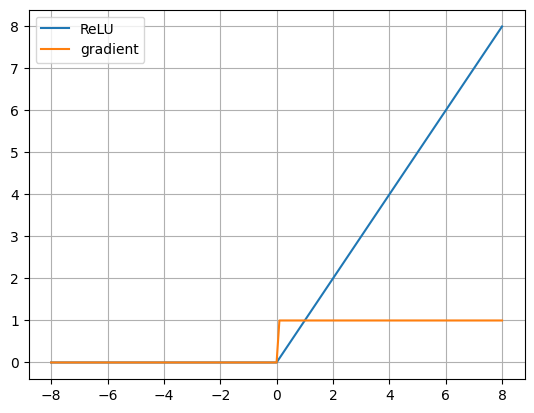

In [46]:
plt.plot(x, relu_out, label='ReLU')
plt.plot(x, relu_der, label='gradient')
plt.grid(True)
plt.legend()
plt.show()

## Softmax

In [47]:
soft_out = sigmoid(x)
soft_der = loss_sigmoid_der(ones, soft_out)

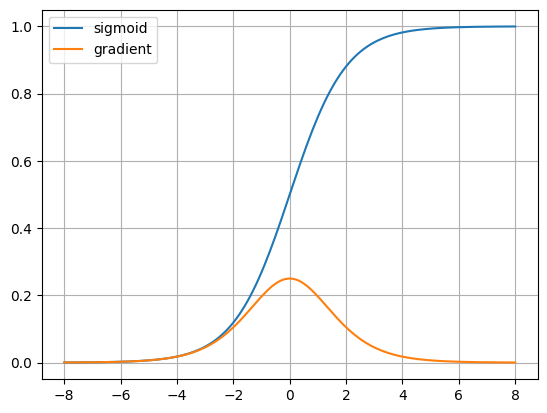

In [48]:
plt.plot(x, soft_out, label='sigmoid')
plt.plot(x, soft_der, label='gradient')
plt.grid(True)
plt.legend()
plt.show()

## Tanh

In [49]:
tanh_out = tanh(x)
tanh_der = loss_tanh_der(ones, tanh_out)

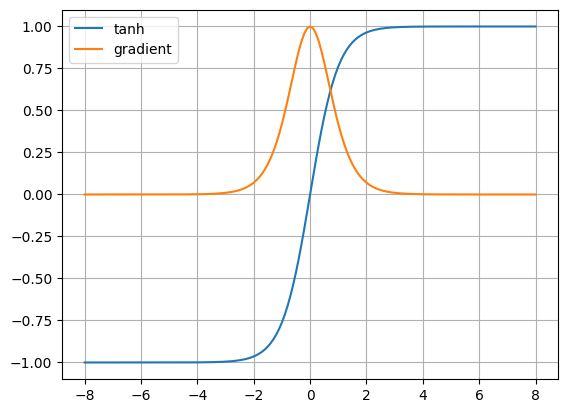

In [50]:
plt.plot(x, tanh_out, label='tanh')
plt.plot(x, tanh_der, label='gradient')
plt.grid(True)
plt.legend()
plt.show()

We can observe that the sigmoid and tanh gradients tend to be $0$
when the inputs are at the edges. 
ReLU is the most numerically stable of these functions.

# Appendix

$$
\begin{align*}
\frac{\mathrm{d} \text{Sigmoid}}{\mathrm{d} z}
&= \frac{\exp(-z)}{\left(1 + \exp(-z) \right)^{2}} \\
&= \frac{1}{1 + \exp(-z)} \left(
    \frac{\exp(-z)}{1 + \exp(-z)}
\right) \\
&= \frac{1}{1 + \exp(-z)} \left(
    \frac{1 + \exp(-z)}{1 + \exp(-z)} -
    \frac{1}{1 + \exp(-z)}
\right) \\
&= \frac{1}{1 + \exp(-z)} \left(
    1 - \frac{1}{1 + \exp(-z)}
\right) \\
&= \text{Sigmoid}(z) \left(1 - \text{Sigmoid}(z) \right)
\end{align*}
$$